# Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


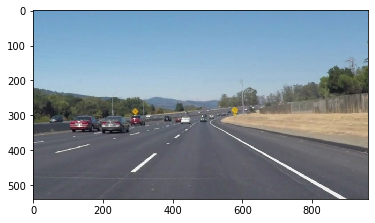

In [2]:
import os

#reading in an image
#yui = mpimg.imread('test_images/solidWhiteCurve.jpg')
#yu = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = []
image.append(mpimg.imread('test_images/solidWhiteCurve.jpg'))
image.append(mpimg.imread('test_images/solidWhiteRight.jpg'))
image.append(mpimg.imread('test_images/solidYellowCurve.jpg'))
image.append(mpimg.imread('test_images/solidYellowCurve2.jpg'))
image.append(mpimg.imread('test_images/solidYellowLeft.jpg'))
image.append(mpimg.imread('test_images/whiteCarLaneSwitch.jpg'))

#printing out some stats and plotting
for img in image:
    print('This image is:', type(img), 'with dimensions:', img.shape)

plt.imshow(image[0])

## Line detection pipeline

### Grayscale conversion

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

### Gaussian smoothing

In [4]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

### Canny Edges

In [5]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

### Mask

In [6]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Hough Transform

In [7]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

### Lines

In [8]:
def linearRegression(img, lines): 
    img = np.copy(img) * 0 # creating a blank to draw lines on
    xL = []
    yL = []
    xR = []
    yR = []

    for line in lines:
            for x1,y1,x2,y2 in line:
                if ((y2-y1)/(x2-x1)) < 0:     
                    xL += [x1, x2]
                    yL += [y1, y2]
                else:
                    xR += [x1, x2]
                    yR += [y1, y2]

    zL = np.polyfit(xL, yL,1)
    mL, bL = zL
    zR = np.polyfit(xR, yR,1)
    mR, bR = zR
    min_yL = int(round(min(xL) * mL + bL))
    max_yL = int(round(max(xL) * mL + bL))
    min_yR = int(round(min(xR) * mR + bR))
    max_yR = int(round(max(xR) * mR + bR))
    cv2.line(img, (min(xL), min_yL), (max(xL), max_yL), [255, 0, 0], 6)
    cv2.line(img, (min(xR), min_yR), (max(xR), max_yR), [255, 0, 0], 6)
    return img

    #for i in range(min(xL), max(xL)):
     #   plt.plot(i, i * mL + bL, 'r.')

    #for i in range(min(xR), max(xR)):
    #    linesImg = plt.plot(i, i * mR + bR, 'r.')
    #return img
    


### Weighted image

In [9]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Pipeline

In [10]:
def process_image(img):
    plt.imshow(img)
    grayImg = grayscale(img)
    plt.imshow(grayImg, cmap='gray')

    gaussImg = gaussian_blur(grayImg, 5)

    cannyImg = canny(gaussImg, 50, 150)
    plt.imshow(cannyImg, cmap='Greys_r')

    imshape = img.shape
    vertices = np.array([[(100,imshape[0]),(400, 360), (600, 360), (imshape[1],imshape[0])]], dtype=np.int32)
    maskedImg = region_of_interest(cannyImg, vertices);
    plt.imshow(maskedImg)

    houghImg, lines = hough_lines(maskedImg, 2, np.pi/180, 15, 50, 120)

    linesImg = linearRegression(houghImg, lines)
    
    weightedImg = weighted_img(linesImg, img, 0.8, 1, 0)
    return weightedImg

### Save results

True

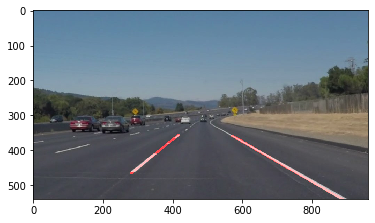

In [11]:
img = process_image(image[0])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidWhiteCurveOut.png", img) 

True

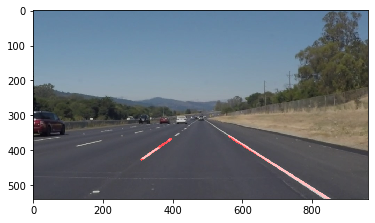

In [12]:
img = process_image(image[1])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidWhiteRightOut.png", img) 

True

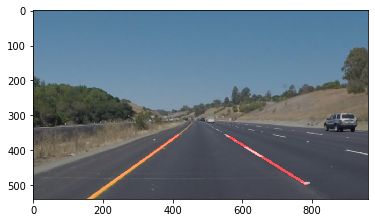

In [13]:
img = process_image(image[2])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidYellowCurveOut.png", img) 

True

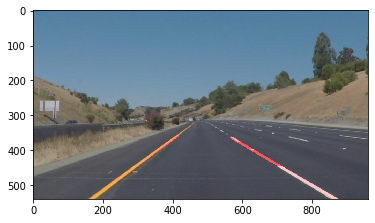

In [14]:
img = process_image(image[3])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidYellowCurve2Out.png", img) 

True

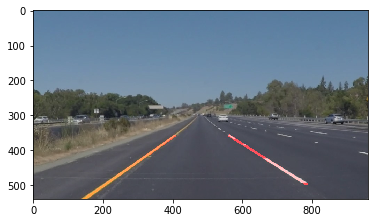

In [15]:
img = process_image(image[4])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/solidYellowLeftOut.png", img) 

True

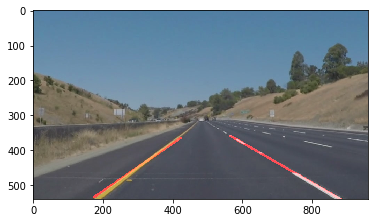

In [20]:
img = process_image(image[5])
plt.imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite("test_images_output/whiteCarLaneSwitchOut.png", img) 

t:   1%|▉                                                                    | 3/221 [00:00<00:11, 19.75it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 16.3 s


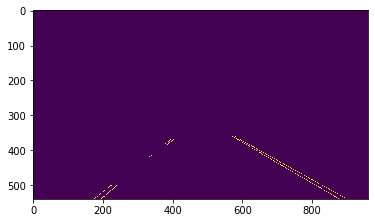

In [21]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|▏                                                                    | 2/681 [00:00<00:35, 18.90it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 49.5 s


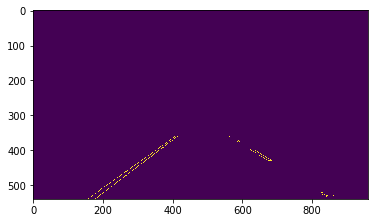

In [23]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)